# Principal Component Analysis (PCA) 

Say I have a data-set `X`:

In [1]:
import numpy as np
X = np.genfromtxt("PCA_data.txt")
X.shape

(400, 2)

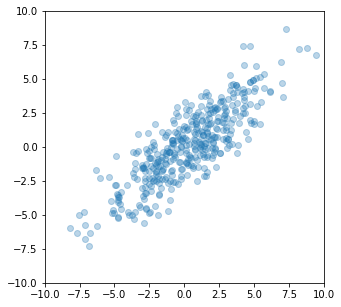

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(5,5))
plt.axis([-10,10,-10,10])
plt.scatter(X[:,0], X[:,1], alpha=0.3)

We want to find the direction along which the data varies most and least, i.e. the directions of the red and black arrows in the following plot: 

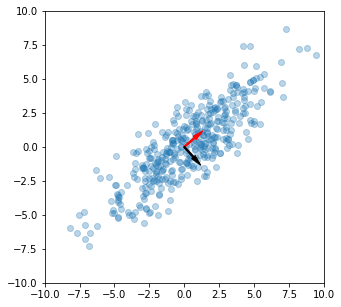

In [3]:
# we'll compute these vectors later
v1 = [ 0.74980752,  0.66165601]
v2 = [ 0.66165601, -0.74980752]

plt.figure(figsize=(5,5))
plt.axis([-10,10,-10,10])
plt.scatter(X[:,0], X[:,1], alpha=0.3)
plt.arrow(0, 0, v1[0], v1[1], width=0.1, head_width=0.34, head_length=0.8, color="red")
plt.arrow(0, 0, v2[0], v2[1], width=0.1, head_width=0.34, head_length=0.8, color="black")

Finding these directions, called principal components, can be very useful when your data is high-dimensional but only a few of the directions account for most of the variation. For example, if the data lived in 1000-dimensional space, but almost all of the variation occurred along the red arrow, you could approximate each data-point quite well using the red arrow only. That would aid visualization and allow you to compress the data because each data point would now be represented by a single coordinate instead of 1000 of them. 

# Singular Value Decomposition (SVD)

SVD can be used to find the principal components of a data set. 

Let $X$ be the $m\times n$ matrix whose rows are the data-points. There are $m$ data points and each data point has $n$ dimensions. Decompose $X$ using the Singular Value Decomposition (SVD):

$$X = U \Sigma V^T$$

Here, $\Sigma$ is a diagonal matrix whose diagonal entries are positive and in decreasing order (the largest lies in the upper left corner of $\Sigma$). The other matrices, $U$ and $V$, are orthogonal matrices, i.e. their columns are orthonormal vectors.

The columns of $V$ are the significant directions we were looking for. $\Sigma$'s entries are the amount of variance of the data in that direction. Finally, $U$ (or more precisely $U\Sigma$) stores how you write each row of $X$ in terms of the columns of $V$. 



### Question

Figure out how to use scipy's `linalg.svd` function and use it compute the principal components of the data set. 

### Solution

In [4]:
import scipy.linalg

U, sigma, Vt = scipy.linalg.svd(X)

In [5]:
sigma # diagonal elements of matrix Sigma

array([ 79.77145457,  23.41073082])

In [6]:
Vt # transpose of matrix V

array([[ 0.74980752,  0.66165601],
       [ 0.66165601, -0.74980752]])

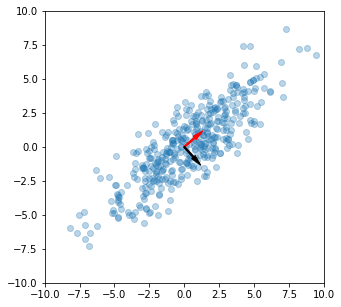

In [7]:
# extract rows of Vt, which are the columns of V
v1 = Vt[0,:]
v2 = Vt[1,:]

plt.figure(figsize=(5,5))
plt.axis([-10,10,-10,10])
plt.scatter(X[:,0], X[:,1], alpha=0.3)
plt.arrow(0, 0, v1[0], v1[1], width=0.1, head_width=0.34, head_length=0.8, color="red")
plt.arrow(0, 0, v2[0], v2[1], width=0.1, head_width=0.34, head_length=0.8, color="black")

# Applying PCA to a data set of faces

In [8]:
X = np.genfromtxt("faces.txt") # load faces dataset
X.shape

(4916, 576)

X has 4916 rows. Each row consists of the values of the pixels of an image of size 24x24

Since the images are flattened (turned into vector of dimension 576 instead of 24x24), we need to reshape them to look at the pictures, so let's define a function that takes a vectorized version of an image and plots it: 

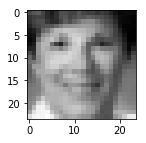

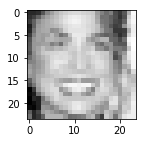

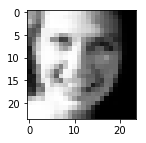

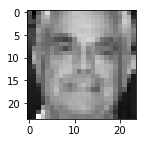

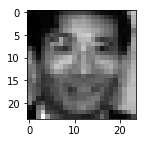

In [9]:
def showimg(imvec):
    plt.figure(figsize=(2,2))
    img = np.reshape(imvec,(24,24))
    plt.imshow(img.T , cmap="gray") 
    
startface = 99
for i in range(startface, startface+5):
    showimg(X[i,:])

### Mean normalization

Recall that we previously computed an image representing the average of all the faces...

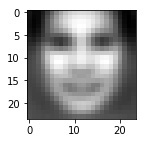

In [10]:
mean_image = np.apply_along_axis(np.mean, 0, X)
showimg(mean_image)

Since each image is really just a vector, we can subtract the mean image vector from each of the image vectors to center them, i.e. so that the vectors are centered at 0:



In [11]:
X_n = X - mean_image

There is a reason for this "mean normalization": If the mean is not zero, the "most significant direction" will be skewed towards the direction of the mean, and we don't want that.

### Computing the SVD of the faces dataset

We are now ready to compute the SVD:

In [12]:
U, s, Vt = scipy.linalg.svd(X_n)

In [13]:
# notice that the singular values are ordered, with largest first
s[:10] 

array([ 53251.34719568,  32595.66505196,  29910.08522183,  21359.27850137,
        17159.4578467 ,  16019.4947119 ,  14029.74221998,  12304.64665821,
        12046.00901233,  11027.43224609])

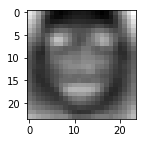

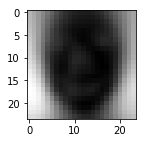

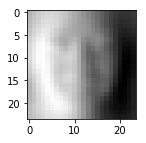

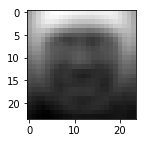

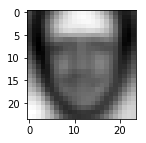

In [14]:
# eigenfaces
for i in range(5): 
    showimg(Vt[i,:])

### Question

Construct the matrix $\Sigma$ from the singular values contained in the variable `s`.

### Solution

In [15]:
m = len(U)
n = len(Vt)
Sigma = np.zeros((m, n))
for i in range(min(m, n)):
    Sigma[i, i] = s[i]
    
print 'shape of U =', U.shape
print 'shape of Vt (or V) =', Vt.shape
print 'shape of Sigma =', Sigma.shape

shape of U = (4916, 4916)
shape of Vt (or V) = (576, 576)
shape of Sigma = (4916, 576)


# Approximating faces

Let's now approximate the data set `X`. We do this by retaining only the first $k$ of the singular values contained in `s` or, equivalently, by retaining only the first $k$ rows and columns of $\Sigma$. We similarly contract $U$ to one containing just the first $k$ columns and contract $V^T$ to one containing just the first $k$ rows. 

This approximation of the matrix `X` is called a **low-rank approximation** because the approximate matrix has rank `k`, which is typically smaller than the rank of `X`. Also, it can be shown that the approximation is the matrix of rank `k` that is closest (under the Frobenius norm) to the original matrix `X`. 

### Question

Construct approximations of `X_n` using its SVD and values of $k$ equal to $1, 10, 30, 85, 250$. If it helps, start by choosing a particular value of $k$, then generalize to arbitrary $k$. 

### Solution

In [16]:
X_n_approximations = [np.dot(U[:,:k], Sigma[:k,:k]).dot(Vt[:k,:]) 
                      for k in [1, 10, 30, 85, 250]]

### Question

Use `plot_approximate_images` (defined below) to compare the various approximations for a single image with the original image. This function shows the original image in the first column (on the left); the remaining columns represent successively better approximations of the original (using larger values of $k$). 

In [17]:
def plot_approximate_images(i): 
    im = X[i,:]

    # Remember that we had centered the data at $(0,0,...,0)$ by subtracing the mean.
    # We must not forget to add the mean back!
    im_approx0 = X_n_approximations[0][i,:] + mean_image
    im_approx1 = X_n_approximations[1][i,:] + mean_image
    im_approx2 = X_n_approximations[2][i,:] + mean_image
    im_approx3 = X_n_approximations[3][i,:] + mean_image
    im_approx4 = X_n_approximations[4][i,:] + mean_image

    fig, axes = plt.subplots(1, 6, figsize=(14,2), subplot_kw={'xticks': [], 'yticks': []})
    axx = axes.flat
    axx[0].imshow(np.reshape(im,(24,24)).T, cmap="gray")

    axx[1].imshow(np.reshape(im_approx0,(24,24)).T, cmap="gray")
    axx[2].imshow(np.reshape(im_approx1,(24,24)).T, cmap="gray")
    axx[3].imshow(np.reshape(im_approx2,(24,24)).T, cmap="gray")
    axx[4].imshow(np.reshape(im_approx3,(24,24)).T, cmap="gray")
    axx[5].imshow(np.reshape(im_approx4,(24,24)).T, cmap="gray")


### Solution

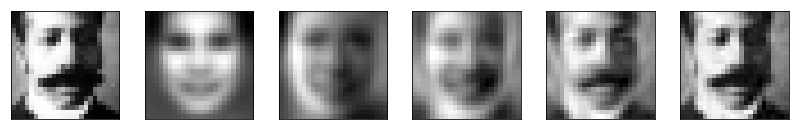

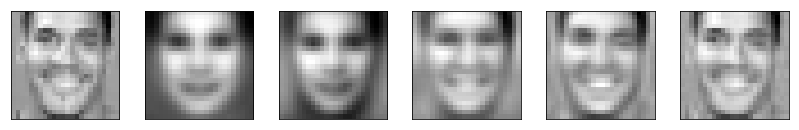

In [18]:
plot_approximate_images(1)
plot_approximate_images(10)